In [1]:
# Common Imports
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, RatchetInterp, multi_factor_value
import pandas as pd
import numpy as np
from IPython.display import display


# Storage Instance
storage = CmdtyStorage(
    freq='D',
    storage_start = '2021-05-01',
    storage_end = '2023-04-01',
    injection_cost = 0.53,
    withdrawal_cost = 0.15,
    ratchet_interp = RatchetInterp.STEP,
    ratchets= [
                ('2021-04-01', # For days after 2021-04-01 (inclusive) until 2022-10-01 (exclusive):
                       [
                            (0.0, -581.0, 763.0),
                            (6426, -1528.0, 763.0),
                            (18207.0, -1528.0, 381.0),
                            (19278.0, -1528.0, 229.0),
                           (21420.0, -1528.0, 229.0)
                        ]),
                 ],
    terminal_storage_npv = lambda spot_price, inventory: 0.0
)
#Forward Prices (EOD or methane prices)
monthly_index = pd.period_range(start='2021-04-25', periods=25, freq='M')
monthly_fwd_prices = [19.29, 19.25, 19.17, 19.2, 19.23, 19.65, 20.33, 20.69, 20.84, 20.88, 20.36,
                      17.61, 16.81, 16.17, 16.45, 16.54, 16.71, 17.45, 18.2, 18.53, 18.84, 18.82,
                      18.32, 16.84, 16.23]
fwd_curve = pd.Series(data=monthly_fwd_prices, index=monthly_index).resample('D').fillna('pad')

#Interest rate curve
rates = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
rates_pillars = pd.PeriodIndex(freq='D', data=['2021-04-25', '2021-06-01', '2021-08-01', '2021-12-01', '2022-04-01',
                                              '2022-12-01', '2023-12-01', '2024-12-01'])
ir_curve = pd.Series(data=rates, index=rates_pillars).resample('D').asfreq('D').interpolate(method='linear')
ir_curve.plot(title='Interest Rate Curve')

#Settlement rule (20 days after delivery date)
def settlement_rule(delivery_date):
    return delivery_date.asfreq('M').asfreq('D', 'end') + 20

# Valuation date, Inventory and discount deltas
val_date = '2021-04-15'
inventory = 0.0
discount_deltas = True

#Least Square monte carlo params
num_sims = 500
seed = 12
fwd_sim_seed = 25

#Three Factor model
spot_mean_reversion = 90.0
spot_vol = 0.40
long_term_vol = 0.20
seasonal_vol = 0.15
three_factor_basis_functions = '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st'

three_factor_results = three_factor_seasonal_value(
    cmdty_storage = storage,
    val_date = val_date,
    inventory = inventory,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = settlement_rule,
    discount_deltas=discount_deltas,
    num_sims = num_sims,
    seed = seed,
    fwd_sim_seed = fwd_sim_seed,
    spot_mean_reversion = spot_mean_reversion,
    spot_vol = spot_vol,
    long_term_vol = long_term_vol,
    seasonal_vol = seasonal_vol,
    basis_funcs = three_factor_basis_functions,
    #numerical_tolerance=0.01,
)
'{0:,.0f}'.format(three_factor_results.npv)

#3 Factor model Valuation Results
print('3-Factor Full NPV:\t{0:,.0f}'.format(three_factor_results.npv))
print('3-Factor Intrinsic NPV:\t{0:,.0f}'.format(three_factor_results.intrinsic_npv))
print('3-Factor Extrinsic NPV:\t{0:,.0f}'.format(three_factor_results.extrinsic_npv))


3-Factor Full NPV:	161,062
3-Factor Intrinsic NPV:	64,356
3-Factor Extrinsic NPV:	96,706


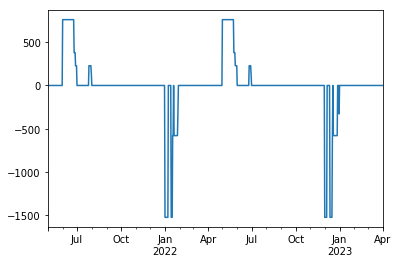

In [2]:
three_factor_results.intrinsic_profile.inject_withdraw_volume.plot()

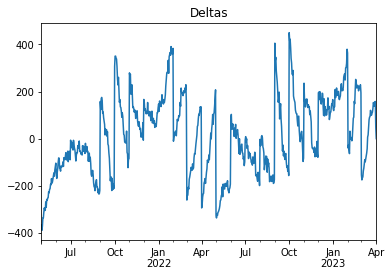

In [3]:
three_factor_results.deltas.plot(title='Deltas')